In [1]:
#|default_exp training

In [2]:
#|export
import gzip, pickle
from pathlib import Path
from urllib.request import urlretrieve
import torch
from torch.utils.data import DataLoader, default_collate
from torch import tensor

In [3]:
# load data
data_path = Path('/home/admin/projects/learn_miniai/nbs/data')
data_path.mkdir(parents=True, exist_ok=True)
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
data_fn = data_path/'mnist.pkl.gz'

if not data_fn.exists(): urlretrieve(MNIST_URL, data_fn)

with gzip.open(data_fn) as f:
    (x_train, y_train), (x_val, y_val), _ = pickle.load(f, encoding='latin')

x_train, y_train, x_val, y_val = map(tensor, (x_train, y_train, x_val, y_val,))
x_train.shape, y_train.shape

(torch.Size([50000, 784]), torch.Size([50000]))

### inital setup

In [4]:
from torch import nn, tensor

In [5]:
n, m = x_train.shape
c = y_train.max() - y_train.min() + 1
nh = 50
print(n,m,nh, c,)

50000 784 50 tensor(10)


In [6]:
class Model(nn.Module):
    def __init__(self, n_int, nh, n_out):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(n_int, nh), nn.ReLU(), nn.Linear(nh, n_out))

    def forward(self, x):
        return self.layers(x)
    
model = Model(m, nh, c)
out = model(x_train)
out.shape

torch.Size([50000, 10])

### Cross entropy loss

In [7]:
import torch
from functools import partial
from matplotlib import pyplot as plt

torch.set_printoptions(precision=2, linewidth=200)

In [8]:
# soft_max
out = out[0:3]
out

tensor([[ 0.17,  0.04,  0.01,  0.01, -0.07,  0.00,  0.13,  0.04,  0.08, -0.02],
        [-0.03,  0.06,  0.13,  0.01, -0.07,  0.09,  0.05,  0.04, -0.05,  0.05],
        [ 0.07,  0.02,  0.11, -0.01, -0.04, -0.02,  0.05, -0.03,  0.18,  0.10]], grad_fn=<SliceBackward0>)

In [9]:
def softmax(out): return out.exp() / out.exp().sum(1, keepdim=True)

In [10]:
def plot_func(f, min=0, max=10):
    x = torch.linspace(min, max, 1000)
    y = f(x)
    plt.figure(figsize=(4, 3))
    plt.plot(x, y)
    plt.show()

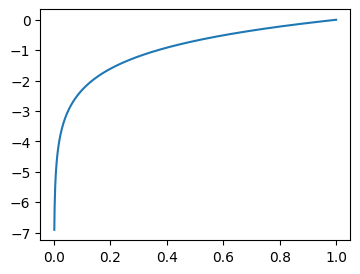

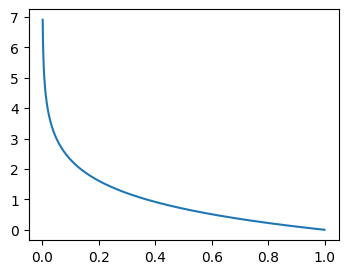

In [11]:
import math

plot_func(torch.log, max=1)
plot_func(lambda x: -torch.log(x), max=1)

In [12]:
log_prob = softmax(out).log()

In [13]:
log_prob

tensor([[-2.17, -2.30, -2.34, -2.34, -2.42, -2.34, -2.21, -2.31, -2.27, -2.36],
        [-2.36, -2.27, -2.20, -2.32, -2.40, -2.24, -2.29, -2.29, -2.38, -2.28],
        [-2.28, -2.33, -2.23, -2.36, -2.38, -2.37, -2.29, -2.38, -2.17, -2.25]], grad_fn=<LogBackward0>)

In [14]:
out - out.exp().sum(1, keepdim=True).log()

tensor([[-2.17, -2.30, -2.34, -2.34, -2.42, -2.34, -2.21, -2.31, -2.27, -2.36],
        [-2.36, -2.27, -2.20, -2.32, -2.40, -2.24, -2.29, -2.29, -2.38, -2.28],
        [-2.28, -2.33, -2.23, -2.36, -2.38, -2.37, -2.29, -2.38, -2.17, -2.25]], grad_fn=<SubBackward0>)

In [15]:
def log_softmax(out): return out - out.exp().sum(1, keepdim=True).log()
torch.allclose(log_softmax(out), log_prob)

True

In [16]:
y_train[0:3]

tensor([5, 0, 4])

In [17]:
print(log_prob.shape)
log_prob

torch.Size([3, 10])


tensor([[-2.17, -2.30, -2.34, -2.34, -2.42, -2.34, -2.21, -2.31, -2.27, -2.36],
        [-2.36, -2.27, -2.20, -2.32, -2.40, -2.24, -2.29, -2.29, -2.38, -2.28],
        [-2.28, -2.33, -2.23, -2.36, -2.38, -2.37, -2.29, -2.38, -2.17, -2.25]], grad_fn=<LogBackward0>)

In [18]:
y_train[0:3]

tensor([5, 0, 4])

In [19]:
log_prob[0, 5], log_prob[1, 0], log_prob[2, 4]

(tensor(-2.34, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>),
 tensor(-2.38, grad_fn=<SelectBackward0>))

In [20]:
y_train[0:3].unsqueeze(1).shape

torch.Size([3, 1])

In [21]:
log_prob.gather(1, y_train[0:3].unsqueeze(1))

tensor([[-2.34],
        [-2.36],
        [-2.38]], grad_fn=<GatherBackward0>)

In [22]:
def cross_entropy_loss(out, y):
    log_prob = log_softmax(out)
    loss = -log_prob.gather(1, y.unsqueeze(1)).mean()
    return loss

loss = cross_entropy_loss(out, y_train[0:3]); loss

tensor(2.36, grad_fn=<NegBackward0>)

In [23]:
tensor(1/10).log()

tensor(-2.30)

In [24]:
import torch.nn.functional as F
F.cross_entropy(out, y_train[0:3]) == loss

tensor(False)

### Basic train loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [25]:
loss_func = F.cross_entropy

In [26]:
epoch = 3
bs = 50
lr = 0.1
xb = x_train[0:bs]; print(xb.shape)
yb = y_train[0:bs]; print(yb.shape)
pred = model(xb)
loss = loss_func(pred, yb); loss

torch.Size([50, 784])
torch.Size([50])


tensor(2.33, grad_fn=<NllLossBackward0>)

In [27]:
(pred.argmax(1) == yb).float().mean()

tensor(0.04)

In [28]:
#|export
def accuracy(pred, yb): return (pred.argmax(1) == yb).float().mean()

In [29]:
#|export
def report(loss, pred, yb): print(f"Loss {loss:.2f} and accuracy: {accuracy(pred, yb):.1%}")

In [30]:
report(loss, pred, yb)

Loss 2.33 and accuracy: 4.0%


In [31]:
loss.backward()

In [32]:
for p in model.layers.parameters():
    print(p.shape)
    print(p.grad.shape)

torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10, 50])
torch.Size([10])
torch.Size([10])


In [33]:
for p in model.layers.parameters():
    p.data -= lr * p.grad

In [34]:
pred = model(xb)
loss = loss_func(pred, yb); loss
report(loss, pred, yb)

Loss 2.30 and accuracy: 8.0%


In [35]:
def zero():
    for p in model.layers.parameters():
        p.grad = None

zero()

In [36]:
i = slice(1, 30)

In [37]:
for _ in range(epoch):
    for i in range(0, n, bs):
        ib = slice(i, min(i + bs, n))
        xb, yb = x_train[ib], y_train[ib]
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        with torch.no_grad():
            for p in model.layers.parameters():
                p.data -= lr * p.grad
                p.grad.zero_()
    report(loss, pred, yb)

Loss 0.23 and accuracy: 92.0%
Loss 0.15 and accuracy: 94.0%
Loss 0.11 and accuracy: 94.0%


### Optim

In [38]:
class Optim():
    def __init__(self, parameters):
        self.parameters = list(parameters)
        
    def step(self):
        with torch.no_grad():
            for p in self.parameters: p.data -= lr * p.grad
            
    def zero_grad(self):
        with torch.no_grad():
            for p in self.parameters: p.grad.zero_()

model = Model(m, nh, c)
optim = Optim(model.layers.parameters())

for _ in range(epoch):
    for i in range(0, n, bs):
        ib = slice(i, min(i + bs, n))
        xb, yb = x_train[ib], y_train[ib]
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        optim.step()
        optim.zero_grad()
    report(loss, pred, yb)

Loss 0.23 and accuracy: 92.0%
Loss 0.14 and accuracy: 94.0%
Loss 0.11 and accuracy: 96.0%


In [39]:
from torch.optim import SGD

In [40]:
def get_model():
    model = Model(m, nh, c)
    optim = SGD(model.parameters(), lr=lr)
    return model, optim

model, optim = get_model()

for _ in range(epoch):
    for i in range(0, n, bs):
        ib = slice(i, min(i + bs, n))
        xb, yb = x_train[ib], y_train[ib]
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        optim.step()
        optim.zero_grad()
    report(loss, pred, yb)

Loss 0.21 and accuracy: 92.0%
Loss 0.14 and accuracy: 94.0%
Loss 0.10 and accuracy: 94.0%


In [41]:
# Dateset and DataLoader

In [42]:
#|export
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [43]:
ds_train = Dataset(x_train, y_train)

len(ds_train)
x, y = ds_train[0]
x.shape, y

(torch.Size([784]), tensor(5))

In [44]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i + self.bs]

dl_train = DataLoader(ds_train, bs)

next(iter(dl_train))

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3]))

In [45]:
model, optim = get_model()
def fit(epoch):
    for _ in range(epoch):
        for xb, yb in dl_train:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            optim.step()
            optim.zero_grad()
        report(loss, pred, yb)
        
fit(epoch)

Loss 0.22 and accuracy: 92.0%
Loss 0.13 and accuracy: 98.0%
Loss 0.08 and accuracy: 98.0%


### Random sampling

In [46]:
import random
from itertools import islice
class Sample():
    def __init__(self, x, shuffle=False):
        self.n, self.shuffle = len(x), shuffle
    def __iter__(self):
        idxs = list(range(self.n))
        if self.shuffle == True: random.shuffle(idxs)
        return iter(idxs)
    
sample = Sample(x_train); print(list(islice(sample, 3)))
# sample = Sample(x_train, shuffle=True); print(list(islice(sample, 3)))

[0, 1, 2]


In [47]:
bs = 4
sample = iter(sample)
get_batch = lambda: list(islice(sample, bs))

In [48]:
for i in range(4): print(get_batch())

[0, 1, 2, 3]
[4, 5, 6, 7]
[8, 9, 10, 11]
[12, 13, 14, 15]


In [49]:
bs = 4

class BatchSample():
    def __init__(self, x, bs, shuffle=False):
        self.sample = Sample(x, shuffle)
        self.bs = bs
    def __iter__(self):
        sample = iter(self.sample) 
        return iter(lambda: list(islice(sample, bs)), [])

In [50]:
batch_sample = BatchSample(x_train, 4, shuffle=False)

for i, b in enumerate(batch_sample):
    print(i, b)
    if i > 4: break

0 [0, 1, 2, 3]
1 [4, 5, 6, 7]
2 [8, 9, 10, 11]
3 [12, 13, 14, 15]
4 [16, 17, 18, 19]
5 [20, 21, 22, 23]


In [51]:
batch_sample = BatchSample(x_train, 4, shuffle=True)

for i, b in enumerate(batch_sample):
    print(i, b)
    if i > 4: break

0 [11417, 11279, 49588, 1614]
1 [7094, 43262, 5472, 13949]
2 [16940, 16486, 46192, 39254]
3 [22449, 18432, 15393, 31571]
4 [5222, 7010, 7931, 26145]
5 [7697, 24429, 28705, 36702]


In [52]:
ds_train[b]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([7, 0, 4, 6]))

In [53]:
# put BatchSample into DataLoader
class DataLoader():
    def __init__(self, ds, bs, shuffle=False): self.ds, self.bs, self.shuffle = ds, bs, shuffle
    def __iter__(self):
        batch_sample = BatchSample(self.ds, bs, self.shuffle)
        for b in batch_sample: yield self.ds[b]

In [54]:
dl_train = DataLoader(ds_train, bs)
xb, yb = next(iter(dl_train))
xb.shape, yb

(torch.Size([4, 784]), tensor([5, 0, 4, 1]))

In [55]:
dl_train = DataLoader(ds_train, bs, shuffle=True)
xb, yb = next(iter(dl_train))
xb.shape, yb

(torch.Size([4, 784]), tensor([0, 0, 6, 1]))

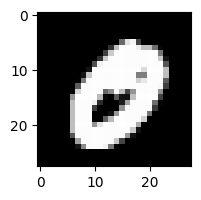

In [56]:
plt.figure(figsize=(2,2))
plt.imshow(xb[0].view(28, 28), cmap='gray')

In [57]:
model, optim = get_model()
dl_train = DataLoader(ds_train, bs=50, shuffle=False)
def fit(epoch):
    for _ in range(epoch):
        for xb, yb in dl_train:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            optim.step()
            optim.zero_grad()
        report(loss, pred, yb)
        
fit(epoch)

Loss 0.23 and accuracy: 100.0%
Loss 0.81 and accuracy: 75.0%
Loss 1.45 and accuracy: 75.0%


In [58]:
## A collate function is used to customize collation of input samples into a batch for yielding from the data loader
def collate(b):
    # do anything
    return b

In [59]:
class DataLoader():
    def __init__(self, ds, bs, collate, shuffle=False):
        self.ds, self.bs, self.collate, self.shuffle = ds, bs, collate, shuffle
    def __iter__(self):
        batch_sample = BatchSample(self.ds, bs, self.shuffle)
        for b in batch_sample: yield self.collate(self.ds[b])

In [60]:
dl_train = DataLoader(ds_train, bs, collate, shuffle=True)
xb, yb = next(iter(dl_train))
xb.shape, yb

(torch.Size([4, 784]), tensor([7, 7, 3, 1]))

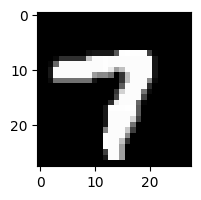

In [61]:
plt.figure(figsize=(2,2))
plt.imshow(xb[0].view(28, 28), cmap='gray')

### All Dateset, Dataloader, Sampler, BatchSampler, collate are already implemented on Pytorch

In [62]:
from torch.utils.data import Dataset

In [63]:
# Dataset is a class with 3 main functions: __init__, __len__, __getitem__
# We have to create a complete new dataset whenever we work with different type of data.

# Using the old class

class CustomDataset(Dataset):
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

ds_train = CustomDataset(x_train, y_train)
ds_val = CustomDataset(x_val, y_val)
print(len(ds_train), len(ds_val))
x, y = ds_train[0]
x.shape, y

50000 10000


(torch.Size([784]), tensor(5))

In [64]:
from torch.utils.data import DataLoader

In [65]:
dl_train = DataLoader(ds_train, batch_size=5)

In [66]:
model, optim = get_model()
dl_train = DataLoader(ds_train, batch_size=50)
def fit(epoch):
    for _ in range(epoch):
        for xb, yb in dl_train:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            optim.step()
            optim.zero_grad()
        report(loss, pred, yb)
        
fit(epoch)

Loss 0.23 and accuracy: 92.0%
Loss 0.16 and accuracy: 96.0%
Loss 0.11 and accuracy: 98.0%


In [67]:
model, optim = get_model()
dl_train = DataLoader(ds_train, batch_size=50, shuffle=True)
def fit(epoch):
    for _ in range(epoch):
        for xb, yb in dl_train:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            optim.step()
            optim.zero_grad()
        report(loss, pred, yb)
        
fit(3)

Loss 0.33 and accuracy: 94.0%
Loss 0.15 and accuracy: 96.0%
Loss 0.22 and accuracy: 94.0%


In [68]:
# Sampler in Dataloader
from torch.utils.data import RandomSampler, SequentialSampler

In [69]:
sampler = RandomSampler(ds_train)
next(iter(sampler))

33826

In [70]:
sampler = SequentialSampler(ds_train)
next(iter(sampler))

0

In [71]:
from torch.utils.data import BatchSampler

In [72]:
bs=50

In [73]:
train_samp = BatchSampler(RandomSampler(ds_train),     batch_size=bs, drop_last=False)
val_samp   = BatchSampler(SequentialSampler(ds_val), batch_size=bs, drop_last=False)

In [74]:
train_dl = DataLoader(ds_train, batch_sampler=train_samp)
val_dl   = DataLoader(ds_val,   batch_sampler=val_samp)

In [75]:
xb, yb = next(iter(train_dl))

In [76]:
def fit(epoch=3):
    for _ in range(epoch):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            optim.step()
            optim.zero_grad()
        report(loss, pred, yb)

In [77]:
model, optim = get_model()        
# fit()

In [78]:
# pytorch auto create batch_sampler and sampler for us
train_dl = DataLoader(ds_train, batch_size=bs, drop_last=False, shuffle=True)
val_dl   = DataLoader(ds_val,   batch_size=bs*2, drop_last=False, shuffle=True)

In [79]:
model, optim = get_model()        
# fit()

In [80]:
#|export
def get_dls(train_ds, val_ds, bs, collate_fn=default_collate, **kwargs):
    train_dl = DataLoader(train_ds, batch_size=bs, drop_last=False, shuffle=True, collate_fn=collate_fn, **kwargs)
    val_dl   = DataLoader(val_ds,   batch_size=bs*2, drop_last=False, shuffle=True, collate_fn=collate_fn, **kwargs)
    return train_dl, val_dl

In [81]:
model, optim = get_model()
train_dl, val_dl = get_dls(ds_train, ds_val, bs)
# fit()

In [82]:
#|export
def fit(epoch, model, loss_func, opt, train_dl, val_dl):
    for _ in range(epoch):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0, 0
            for xb, yb in val_dl:
                pred = model(xb)
                loss = loss_func(pred, yb)
                tot_loss += loss.item()
                tot_acc += (pred.argmax(1) == yb).float().sum().item()
            print(f"Loss {tot_loss/len(val_dl.dataset):.4f}. Acc = {tot_acc/len(val_dl.dataset):.2f}")

In [83]:
model, opt = get_model()
train_dl, valid_dl = get_dls(ds_train, ds_val, bs)

In [84]:
%time fit(3, model, loss_func, opt, train_dl, valid_dl)

Loss 0.0024. Acc = 0.93
Loss 0.0019. Acc = 0.95
Loss 0.0018. Acc = 0.95
CPU times: user 26.2 s, sys: 7.97 ms, total: 26.2 s
Wall time: 2.18 s


In [85]:
#|export
from typing import Mapping

def_device = 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x):
    if isinstance(x, torch.Tensor): return x.to(def_device)
    if isinstance(x, Mapping): return {k: v.to(def_device) for k,v in x.items()}
    return type(x)(o.to(def_device) for o in x)

def collate_device(b): return to_device(default_collate(b))

In [86]:
train_dl, valid_dl = get_dls(ds_train, ds_val, bs, collate_device)

In [87]:
%time fit(3, model.to(def_device), loss_func, opt, train_dl, valid_dl)

Loss 0.0014. Acc = 0.96
Loss 0.0013. Acc = 0.96
Loss 0.0012. Acc = 0.97
CPU times: user 3.41 s, sys: 316 ms, total: 3.73 s
Wall time: 3.33 s


In [88]:
import nbdev; nbdev.nbdev_export()